In [14]:
import pandas as pd
import numpy as np
from PIL import Image
import cv2 as cv
import os
from time import sleep
from tqdm.auto import tqdm

from sklearn.metrics import precision_recall_fscore_support, accuracy_score
from collections import OrderedDict
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

In [15]:
# base_path = 'D:/AI Courses/Semester 3/Hardware Technologies for AI/Project/Operational Data/'
# data_path = '/Small Data Set/Small set data/'
# imgs_path = '/Small Data Set/Small set images/'
headers_path = './Data Column Headings.csv'
# labels_path = 'Small Data Set Labels-1.xlsx'
df_path = 'Small Data Set.csv'

In [16]:
headers = pd.read_csv(headers_path)
df = pd.read_csv(df_path)

In [17]:
df

,Images,Data,Labels
0,D:/AI Courses/Semester 3/Hardware Technologies...,D:/AI Courses/Semester 3/Hardware Technologies...,7
1,D:/AI Courses/Semester 3/Hardware Technologies...,D:/AI Courses/Semester 3/Hardware Technologies...,6
2,D:/AI Courses/Semester 3/Hardware Technologies...,D:/AI Courses/Semester 3/Hardware Technologies...,7
3,D:/AI Courses/Semester 3/Hardware Technologies...,D:/AI Courses/Semester 3/Hardware Technologies...,7
4,D:/AI Courses/Semester 3/Hardware Technologies...,D:/AI Courses/Semester 3/Hardware Technologies...,3
...,...,...,...
93,D:/AI Courses/Semester 3/Hardware Technologies...,D:/AI Courses/Semester 3/Hardware Technologies...,5
94,D:/AI Courses/Semester 3/Hardware Technologies...,D:/AI Courses/Semester 3/Hardware Technologies...,6
95,D:/AI Courses/Semester 3/Hardware Technologies...,D:/AI Courses/Semester 3/Hardware Technologies...,6
96,D:/AI Courses/Semester 3/Hardware Technologies...,D:/AI Courses/Semester 3/Hardware Technologies...,5


In [18]:
label_dist = dict(df['Labels'].value_counts())

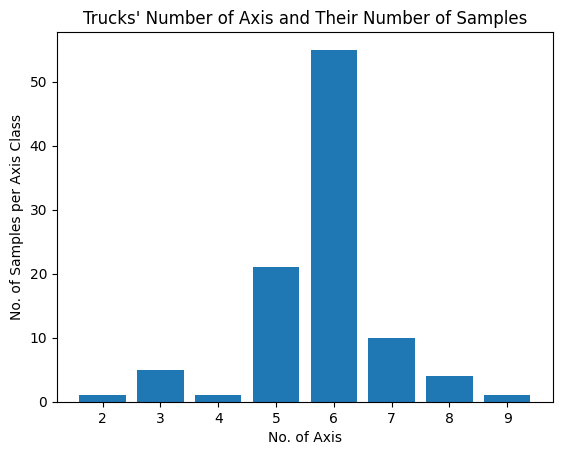

In [19]:
plt.bar(list(label_dist.keys()), list(label_dist.values()))
plt.xlabel("No. of Axis") 
plt.ylabel("No. of Samples per Axis Class") 
plt.title("Trucks' Number of Axis and Their Number of Samples")
plt.show()

In [20]:
num_classes = np.unique(df['Labels']).shape[0]

In [21]:
df['Labels'] = df['Labels'].apply(lambda x: x - 2)

In [22]:
df

,Images,Data,Labels
0,D:/AI Courses/Semester 3/Hardware Technologies...,D:/AI Courses/Semester 3/Hardware Technologies...,5
1,D:/AI Courses/Semester 3/Hardware Technologies...,D:/AI Courses/Semester 3/Hardware Technologies...,4
2,D:/AI Courses/Semester 3/Hardware Technologies...,D:/AI Courses/Semester 3/Hardware Technologies...,5
3,D:/AI Courses/Semester 3/Hardware Technologies...,D:/AI Courses/Semester 3/Hardware Technologies...,5
4,D:/AI Courses/Semester 3/Hardware Technologies...,D:/AI Courses/Semester 3/Hardware Technologies...,1
...,...,...,...
93,D:/AI Courses/Semester 3/Hardware Technologies...,D:/AI Courses/Semester 3/Hardware Technologies...,3
94,D:/AI Courses/Semester 3/Hardware Technologies...,D:/AI Courses/Semester 3/Hardware Technologies...,4
95,D:/AI Courses/Semester 3/Hardware Technologies...,D:/AI Courses/Semester 3/Hardware Technologies...,4
96,D:/AI Courses/Semester 3/Hardware Technologies...,D:/AI Courses/Semester 3/Hardware Technologies...,3


In [23]:
np.unique(df['Labels'])

array([0, 1, 2, 3, 4, 5, 6, 7], dtype=int64)

In [24]:
rcnn = models.detection.fasterrcnn_resnet50_fpn_v2(weights='DEFAULT')
rcnn.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

RESIZE = 448
BATCH_SIZE = 16
SPLIT_PERCENT = 0.75
EMBEDD_DIM = 9995

COCO_INSTANCE_CATEGORY_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']

In [25]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((RESIZE, RESIZE)),
        # transforms.GaussianBlur((19, 19)),
        # transforms.RandomAffine(0, shear=10, scale=(0.9,1.1)),
        transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation(10),
        # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
        normalize
    ]),
    'other':
    transforms.Compose([
        transforms.Resize((RESIZE, RESIZE)),
        # transforms.GaussianBlur((19, 19)),
        transforms.ToTensor(),
        normalize
    ]),
    'rcnn':
    transforms.Compose([
        transforms.Resize((RESIZE, RESIZE)),
        # transforms.GaussianBlur((19, 19)),
        transforms.ToTensor(),
        # normalize
    ]),
    'rcnn_v':
    transforms.Compose([
        transforms.Resize((RESIZE, RESIZE)),
        # transforms.ToTensor(),
        # normalize
    ])
}

In [26]:
def extract_trucks(model, img, transform=None):

    model.eval()
    img_rcnn = data_transforms['rcnn'](img)
    img_v = np.array(data_transforms['rcnn_v'](img))
    c, w, h = img_rcnn.shape

    res = model(img_rcnn.reshape((1, c, w, h)))
    bboxes, lbls = res[0]['boxes'].detach(), res[0]['labels']
    bboxes = [np.array(each, dtype=int) for each in bboxes]
    bboxes = np.array(bboxes)

    trucks_bboxs = []

    for i, each_lbl in enumerate(lbls):
        if each_lbl == 8:
            trucks_bboxs.append(bboxes[i])

    if len(trucks_bboxs) > 0:
        max_wh = 0
        max_wh_id = 0
    
        for i, (x, y, a, b) in enumerate(trucks_bboxs):
            w = a - x
            h = b - y
        
            if w + h > max_wh:
                max_wh = w + h
                max_wh_id = i
    
    
        truck = trucks_bboxs[max_wh_id]

        img_crop = img_v[truck[1]: truck[3], truck[0]: truck[2]]
    
    else:
        img_crop = img_v

    if transform:
        img_crop = transform(Image.fromarray(img_crop))

    return img_crop

In [27]:
exmpl_strain_path = df.iloc[2][1]

In [28]:
csv_file = pd.read_csv(exmpl_strain_path)
csv_file.columns = headers.columns

In [29]:
csv_file

,Date,Sample_Number,Sum of strains mid span,G19,G22,G25,G28,G7,G10,G13,...,G5,G2,G4,G6,G31,G32,TC1,TC2,TC3,TC4
0,20170501.0,-999.0,-1.4,-0.1,0.3,-1.0,-0.7,0.1,0.3,0.8,...,-0.6,0.0,0.2,-0.5,-0.2,0.0,14.2,15.1,14.7,16.8
1,20170501.0,-998.0,-1.8,-0.2,0.0,-0.9,-0.8,0.1,0.2,0.4,...,-0.6,0.3,-0.1,-0.7,-0.2,0.0,14.2,15.1,14.7,16.8
2,20170501.0,-997.0,-1.3,-0.0,-0.0,-0.6,-0.7,0.1,-0.1,0.4,...,-0.4,0.3,0.0,-0.3,-0.1,0.0,14.2,15.1,14.7,16.8
3,20170501.0,-996.0,-1.4,-0.2,-0.0,-0.5,-0.6,0.1,-0.2,0.5,...,-0.3,-0.1,-0.1,-0.2,-0.2,0.0,14.2,15.1,14.7,16.8
4,20170501.0,-995.0,-1.4,-0.3,-0.1,-0.4,-0.6,0.1,-0.3,0.0,...,-0.1,0.1,0.3,0.2,0.3,0.0,14.2,15.1,14.7,16.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994,20170501.0,995.0,-1.1,-0.5,-0.2,-0.0,-0.3,-0.2,0.5,0.0,...,-0.0,-0.4,0.5,0.7,0.3,0.0,14.2,15.1,14.7,16.8
1995,20170501.0,996.0,-0.8,-0.3,-0.3,-0.1,-0.2,-0.3,0.0,0.2,...,0.3,-0.3,0.4,0.8,0.2,0.0,14.2,15.1,14.7,16.8
1996,20170501.0,997.0,0.2,0.2,-0.1,0.3,-0.2,0.1,-0.1,0.2,...,0.4,-0.4,0.3,0.6,0.0,0.0,14.2,15.1,14.7,16.8
1997,20170501.0,998.0,-0.7,0.2,-0.4,-0.1,-0.4,-0.1,-0.3,-0.0,...,0.1,-0.1,0.3,0.1,-0.1,0.0,14.2,15.1,14.7,16.8


In [30]:
class TruckDataset(Dataset):
    def __init__(self,
                df,
                transform=None,
                shuffle_data=True,
                use_rcnn=True):

        self.df = df
        self.transform = transform
        self.use_rcnn = use_rcnn

        if shuffle_data:
            self.df = self.df.sample(frac=1).reset_index(drop=True)



    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx) -> tuple:
        image = Image.open(self.df.iloc[idx, 0]).convert("RGB")
        label = self.df.iloc[idx, 2]
        if self.use_rcnn:
            image = extract_trucks(rcnn, image, self.transform)
        else:
            if self.transform:
                image = self.transform(image)
        
        data = pd.read_csv(self.df.iloc[idx, 1])
        data.columns = headers.columns
        data = data[['Sum of strains mid span', ' TC1', ' TC2', ' TC3', ' TC4']]
        data = torch.from_numpy(data.values)
        data = data.reshape((-1))
        return image, data, label

In [31]:
tr_dt = TruckDataset(df, transform=data_transforms['train'], use_rcnn=False)
ts_dt = TruckDataset(df, transform=data_transforms['other'], use_rcnn=False)


dt_size = len(tr_dt)
indices = list(range(dt_size))
split_idx = int(SPLIT_PERCENT * dt_size)

tr_indices, ts_indices = indices[:split_idx], indices[split_idx:]

tr_sampler = SubsetRandomSampler(tr_indices)
ts_sampler = SubsetRandomSampler(ts_indices)

tr_loader = DataLoader(tr_dt, batch_size=BATCH_SIZE, sampler=tr_sampler)
ts_loader = DataLoader(ts_dt, batch_size=BATCH_SIZE, sampler=ts_sampler)

dataloaders = {
    'train': tr_loader,
    'validation': ts_loader
}

In [32]:
X, y, z = next(iter(tr_loader))
X.shape, y.shape, z.shape

(torch.Size([16, 3, 448, 448]), torch.Size([16, 9995]), torch.Size([16]))

In [33]:
train_len = len(tr_indices)
test_len = len(ts_indices)

In [34]:
del tr_dt, ts_dt, tr_sampler, ts_sampler, tr_indices, ts_indices, tr_loader, ts_loader, indices, split_idx, dt_size

In [35]:
class TrucksCNN(nn.Module):
    def __init__(self, num_features):
        
        super().__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(num_features, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(4, 4),
            nn.Dropout2d(0.1),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.1)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.1),
            # nn.Conv2d(256, 256, 3, padding=1),
            # nn.ReLU(),
            # nn.BatchNorm2d(256),
            # nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.1)
        )
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 512, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.1),
            # nn.Conv2d(512, 512, 3, padding=1),
            # nn.ReLU(),
            # nn.BatchNorm2d(512),
            # nn.MaxPool2d(2, 2),
            # nn.Dropout2d(0.1)
        )
        
        
        # self.fc = nn.Sequential(
        #     nn.Flatten(),
        #     nn.Linear(256 * 3 * 3, 256, True),
        #     nn.BatchNorm1d(256),
        #     nn.Dropout1d(0.1),
        #     nn.Linear(256, 128, True),
        #     nn.BatchNorm1d(128),
        #     nn.Dropout1d(0.1),
        #     nn.Linear(128, 7, True),
        # )


    
    def forward(self, x):

        # print(x.shape)
        x = self.layer1(x)
        # print(x.shape)
        x = self.layer2(x)
        # print(x.shape)
        x = self.layer3(x)
        # print(x.shape)

        return x

In [36]:
# cnn = TrucksCNN(3).to(device)
# cnn(X)

In [37]:
class AttentionLayer(nn.Module):
    def __init__(self, dim):
        super().__init__()

        self.representation_dim = dim
        self.fi_lin = nn.Sequential(
            nn.Linear(self.representation_dim, self.representation_dim, bias=True),
            nn.Linear(self.representation_dim, self.representation_dim, bias=True)
        )
        self.vi_lin = nn.Linear(self.representation_dim, self.representation_dim, bias=False)
        self.vq_lin = nn.Linear(self.representation_dim, self.representation_dim, bias=True)
        self.pi_lin = nn.Linear(self.representation_dim, 1, bias=True)


    def forward(self, fi, vq):

        # print('fi\'s shape:', fi.shape)
        fi = fi.view((fi.shape[0], -1, fi.shape[1]))
        vi = F.tanh(self.fi_lin(fi))
        # print('vi\'s shape:', vi.shape)
        vi2 = self.vi_lin(vi)
        # print('vi2\'s shape:', vi2.shape)
        vq2 = self.vq_lin(vq)
        vq2 = vq2.view((vq2.shape[0], 1, -1))
        # print('vq2\'s shape:', vq2.shape)
        ha = F.tanh(vi2 + vq2)
        # print('ha\'s shape:', ha.shape)
        pi = F.softmax(self.pi_lin(ha), dim=1)
        # print('pi\'s shape:', pi.shape)
        v = torch.sum((pi * vi2), dim=1)
        # print('v\'s shape:', v.shape)
        u = v + vq
        # print('u\'s shape:', u.shape)
        return u

In [38]:
class TruckModel(nn.Module):
    def __init__(self,
                input_representation_shape: int,
                embedd_dim: int,
                num_classes: int,
                num_lstm_layers: int=2,
                ) -> None:
        super().__init__()

        self.txt_encoder = nn.GRU(embedd_dim, input_representation_shape, num_lstm_layers, batch_first=True)

        # self.img_encoder = TrucksCNN(3)
        self.img_encoder = models.resnet18(weights='DEFAULT')
        self.img_encoder = torch.nn.Sequential(OrderedDict([*(list(self.img_encoder.named_children())[:-2])]))
        for param in self.img_encoder.parameters():
            param.requires_grad = False
        # self.img_encoder.layer4[1].conv2.weight.requires_grad = True
        # self.img_encoder.layer4[1].bn2.weight.requires_grad = True
        # self.img_encoder.layer4[1].bn2.bias.requires_grad = True

        self.att1 = AttentionLayer(input_representation_shape)
        self.att2 = AttentionLayer(input_representation_shape)
        self.fc = nn.Linear(input_representation_shape, num_classes)


    def forward(self, vi: torch.Tensor, vq: torch.Tensor) -> torch.Tensor:
        q = self.txt_encoder(vq)[0]
        # print(q.shape)
        i = self.img_encoder(vi)
        u = self.att1(i, q)
        u = self.att2(i, u)
        u = F.softmax(self.fc(u), dim=1)
        return u

In [59]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('-' * 50)
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            with tqdm(dataloaders[phase], unit='batch', position=0, leave=True) as pbar:
                for img, data, lbl in pbar:

                    pbar.set_description(f"Epoch {epoch+1}")

                    img = img.to(device)
                    data = data.to(device).to(torch.float32)
                    lbl = lbl.to(device)
                    outputs = model(img,  data)
                    loss = criterion(outputs, F.one_hot(lbl, num_classes=num_classes).float())

                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                    _, preds = (torch.max(outputs, 1))
                    running_loss += loss.item()
                    running_corrects += torch.sum(preds == lbl.data)
                    pbar.set_postfix(loss=loss.item() / BATCH_SIZE, accuracy=torch.sum(preds == lbl.data).item() / BATCH_SIZE)
                    sleep(0.1)

            epoch_loss = running_loss / (train_len if phase == 'train' else test_len)
            epoch_acc = running_corrects.double() / (train_len if phase == 'train' else test_len)

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

    return model

In [55]:
def evaluate(model, dataloaders):

    model.eval()
    
    prec_rec_f1 = {'train': [[], [], []], 'validation': [[], [], []]}
    acc = {'train': [], 'validation': []}

    for phase in ['train', 'validation']:
        
        with tqdm(dataloaders[phase], unit='batch', position=0, leave=True) as pbar:
            
            for X, y, z in pbar: 
                X = X.to(device)
                y = y.to(device).to(torch.float32)
                z = z.to(device)
                
                outputs = model(X, y)
                _, preds = (torch.max(outputs, 1))
                
                batch_prec_rec_f1_score = precision_recall_fscore_support(np.array(z.cpu()), np.array(preds.cpu()), average='micro')
                batch_acc = accuracy_score(np.array(z.cpu()), np.array(preds.cpu()))
                
                prec_rec_f1[phase][0].append(batch_prec_rec_f1_score[0])
                prec_rec_f1[phase][1].append(batch_prec_rec_f1_score[1])
                prec_rec_f1[phase][2].append(batch_prec_rec_f1_score[2])
                acc[phase].append(batch_acc)
                
                pbar.set_postfix(prec=batch_prec_rec_f1_score[0],
                                            rec=batch_prec_rec_f1_score[1],
                                            f1=batch_prec_rec_f1_score[2],
                                            acc=batch_acc)


        prec_rec_f1[phase][0] = np.mean(np.array(prec_rec_f1[phase][0]))
        prec_rec_f1[phase][1] = np.mean(np.array(prec_rec_f1[phase][1]))
        prec_rec_f1[phase][2] = np.mean(np.array(prec_rec_f1[phase][2]))
        acc[phase] = np.mean(np.array(acc[phase]))


    print(f'Precision on train set: {prec_rec_f1["train"][0]}')
    print(f'Precision on validation set: {prec_rec_f1["validation"][0]}')
    print()
    print(f'Recall on train set: {prec_rec_f1["train"][1]}')
    print(f'Recall on validation set: {prec_rec_f1["validation"][1]}')
    print()
    print(f'F1-Score on train set: {prec_rec_f1["train"][2]}')
    print(f'F1-Score on validation set: {prec_rec_f1["validation"][2]}')
    print()
    print(f'Accuracy on train set: {acc["train"]}')
    print(f'Accuracy on validation set: {acc["validation"]}')

In [61]:
torch.manual_seed(42)
model = TruckModel(input_representation_shape=512, embedd_dim=EMBEDD_DIM, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters())

model_trained = train_model(model, criterion, optimizer, num_epochs=10)

--------------------------------------------------
Epoch 1/10
----------


  0%|          | 0/5 [00:00<?, ?batch/s]

train loss: 0.1273, acc: 0.3836


  0%|          | 0/2 [00:00<?, ?batch/s]

validation loss: 0.1491, acc: 0.4000
--------------------------------------------------
Epoch 2/10
----------


  0%|          | 0/5 [00:00<?, ?batch/s]

train loss: 0.1190, acc: 0.5342


  0%|          | 0/2 [00:00<?, ?batch/s]

validation loss: 0.1491, acc: 0.4000
--------------------------------------------------
Epoch 3/10
----------


  0%|          | 0/5 [00:00<?, ?batch/s]

train loss: 0.1204, acc: 0.5342


  0%|          | 0/2 [00:00<?, ?batch/s]

validation loss: 0.1491, acc: 0.4000
--------------------------------------------------
Epoch 4/10
----------


  0%|          | 0/5 [00:00<?, ?batch/s]

train loss: 0.1190, acc: 0.5342


  0%|          | 0/2 [00:00<?, ?batch/s]

validation loss: 0.1491, acc: 0.4000
--------------------------------------------------
Epoch 5/10
----------


  0%|          | 0/5 [00:00<?, ?batch/s]

train loss: 0.1197, acc: 0.5342


  0%|          | 0/2 [00:00<?, ?batch/s]

validation loss: 0.1530, acc: 0.4000
--------------------------------------------------
Epoch 6/10
----------


  0%|          | 0/5 [00:00<?, ?batch/s]

train loss: 0.1184, acc: 0.5342


  0%|          | 0/2 [00:00<?, ?batch/s]

validation loss: 0.1550, acc: 0.4000
--------------------------------------------------
Epoch 7/10
----------


  0%|          | 0/5 [00:00<?, ?batch/s]

train loss: 0.1170, acc: 0.5342


  0%|          | 0/2 [00:00<?, ?batch/s]

validation loss: 0.1453, acc: 0.4000
--------------------------------------------------
Epoch 8/10
----------


  0%|          | 0/5 [00:00<?, ?batch/s]

train loss: 0.1190, acc: 0.5342


  0%|          | 0/2 [00:00<?, ?batch/s]

validation loss: 0.1472, acc: 0.4000
--------------------------------------------------
Epoch 9/10
----------


  0%|          | 0/5 [00:00<?, ?batch/s]

train loss: 0.1204, acc: 0.5342


  0%|          | 0/2 [00:00<?, ?batch/s]

validation loss: 0.1491, acc: 0.4000
--------------------------------------------------
Epoch 10/10
----------


  0%|          | 0/5 [00:00<?, ?batch/s]

train loss: 0.1184, acc: 0.5342


  0%|          | 0/2 [00:00<?, ?batch/s]

validation loss: 0.1453, acc: 0.4000


In [62]:
evaluate(model_trained, dataloaders)

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Precision on train set: 0.5263888888888889
Precision on validation set: 0.38541666666666663

Recall on train set: 0.5263888888888889
Recall on validation set: 0.38541666666666663

F1-Score on train set: 0.5263888888888889
F1-Score on validation set: 0.38541666666666663

Accuracy on train set: 0.5263888888888889
Accuracy on validation set: 0.38541666666666663


In [85]:
model_rcnn_path = './models/model_rcnn.pth'
torch.save(model_trained, model_rcnn_path)

In [63]:
model_base_path = './models/model_base.pth'
rcnn_path = './models/model_rcnn.pth'

base = torch.load(model_base_path)
rcnn = torch.load(rcnn_path)

In [64]:
evaluate(base, dataloaders)

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Precision on train set: 0.5361111111111111
Precision on validation set: 0.4340277777777778

Recall on train set: 0.5361111111111111
Recall on validation set: 0.4340277777777778

F1-Score on train set: 0.5361111111111111
F1-Score on validation set: 0.4340277777777778

Accuracy on train set: 0.5361111111111111
Accuracy on validation set: 0.4340277777777778


In [65]:
evaluate(rcnn, dataloaders)

  0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/2 [00:00<?, ?batch/s]

Precision on train set: 0.5263888888888889
Precision on validation set: 0.38541666666666663

Recall on train set: 0.5263888888888889
Recall on validation set: 0.38541666666666663

F1-Score on train set: 0.5263888888888889
F1-Score on validation set: 0.38541666666666663

Accuracy on train set: 0.5263888888888889
Accuracy on validation set: 0.38541666666666663


In [32]:
# exmple_img_path = df.iloc[74][0]
# print(exmple_img_path)
# image = Image.open(exmple_img_path).convert('RGB')

# extract_trucks(rcnn, image).shape
# cv.imshow('image', extract_trucks(rcnn, image))
# cv.waitKey(0)
# cv.destroyAllWindows()

In [58]:
a = {'train': [], 'val': []}
a['train'].append(2)

In [59]:
a

{'train': [2], 'val': []}

In [33]:
# img_transformed = data_transforms['rcnn'](image)

In [34]:
# img_transformed.shape

In [35]:
# c, w, h = img_transformed.shape

# res = rcnn(img_transformed.reshape((1, c, w, h)))

In [36]:
# res[0]